# ICU-DISPO

## Library


In [138]:
import tmle_function_new as tmle_fn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
importlib.reload(tmle_fn)
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from IPython.display import display
import warnings


## Data loading & preprocessing

In [139]:
data_splits = tmle_fn.data_loading("tmle_data.csv", test_size=0.3, random_state=42)
W_train_std, W_test_std, scaler = tmle_fn.data_preprocessing(
                                data_splits['train']['W'], data_splits['test']['W']
                                )
W_A_train_std = pd.concat([W_train_std, pd.DataFrame(data_splits['train']['A'], columns=['A'])], axis=1)
W_A_test_std = pd.concat([W_test_std, pd.DataFrame(data_splits['test']['A'], columns=['A'])], axis=1)

 Sample split summary:
   Total samples: 25710
   Train samples: 17997 (70.0%)
   Test samples: 7713 (30.0%)
   Train treatment prop: 0.926
   Test treatment prop: 0.926


## Set up base learner

In [140]:
base_learners = tmle_fn.get_base_learners(W_train_std.shape[1])                     

## Fitting Q model on training set(AUC, Precision, recall, F-1)

In [141]:
sl = tmle_fn.fit_superlearner(W_A_train_std, data_splits['train']['Y'],base_learners, "Outcome model")


Q_A_train, Q_1_train, Q_0_train, Q_model_train_df_metrices = tmle_fn.predict_Q_models(sl, W_A_train_std, data_splits['train']['Y'], is_test=False)
# Q_A_test, Q_1_test, Q_0_test, Q_model_test_df_metrices = tmle.predict_Q_models(sl, W_A_test_std, is_test=True)
Q_model_train_df_metrices


======  Fitting Outcome model ======  :   6%|▋         | 1/16 [00:00<00:00, 1123.27it/s]Python(12054) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
====== Evaluating Outcome model ======:  12%|█▎        | 2/16 [02:40<18:45, 80.43s/it]  Python(12184) MallocStackLogging: can't 

Outcome model Train CV AUC: 0.8025 (+/- 0.0068)


,set,Precision,Recall,F1,ROC_AUC
0,train,0.802644,0.781538,0.79195,0.878926


## Using downsampling dataset to train g model (orginal g model prediction included)

g-model training samples (downsampled): (2662, 63), A=1 proportion: 0.50


======  Fitting Original Propensity Score Model ======  :   6%|▋         | 1/16 [00:00<00:00, 2380.42it/s]Python(12467) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12902) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
====== Evaluating Original Propensity Score Model ======:  12%|█▎        | 2/16 [19:26<2:16:02, 583.05s/it]Python(13300) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Pyt

Original Propensity Score Model Train CV AUC: 1.0000 (+/- 0.0000)


======  Fitting Base Propensity Score Model ======  :   6%|▋         | 1/16 [00:00<00:00, 2206.37it/s]Python(15017) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15018) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(15022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
                                                                                                      

Base Propensity Score Model Train CV AUC: 1.0000 (+/- 0.0000)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


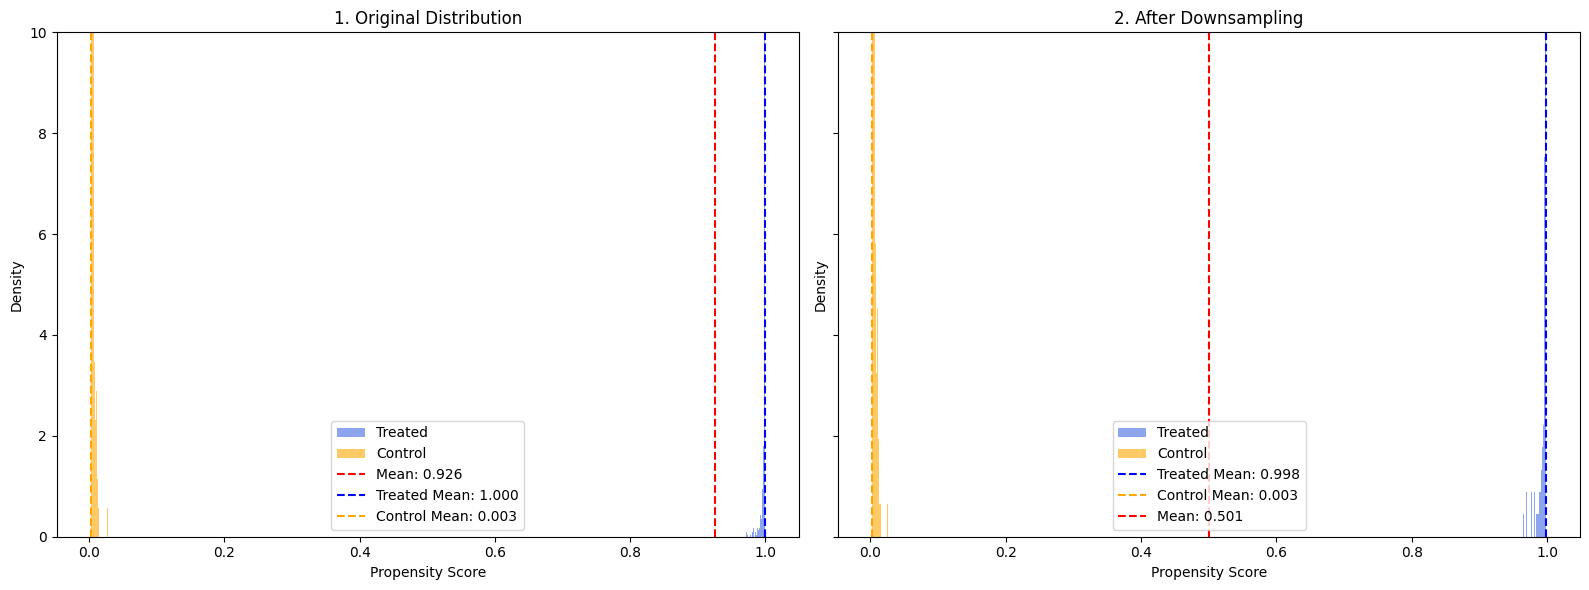

In [142]:
W_down, A_down = tmle_fn.downsampling_g_model_dataset(data_splits['train']['A'], W_train_std, data_splits['test']['A'], W_test_std)

original_g_model = tmle_fn.fit_superlearner(W_train_std, data_splits['train']['A'], base_learners, "Original Propensity Score Model")
original_g_model_probs_train = original_g_model.predict_proba(W_train_std)[:, 1]

base_g_model_down = tmle_fn.fit_superlearner(W_down, A_down, base_learners, "Base Propensity Score Model")
base_g_model_down_probs_train = base_g_model_down.predict_proba(W_down)[:, 1]
# calculate precision, recall, F1-score, ROC-AUC for g model on original training set

# plotting the distributions of predicted probabilities for both original and base g-models
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
# -------- Original g-model distribution --------
treated_original = original_g_model_probs_train[data_splits['train']['A'] == 1]
control_original = original_g_model_probs_train[data_splits['train']['A'] == 0]

axes[0].hist(treated_original, bins=20, alpha=0.6, label="Treated", color="royalblue", density=True)
axes[0].hist(control_original, bins=20, alpha=0.6, label="Control", color="orange", density=True)

mean_original = np.mean(original_g_model_probs_train)
mean_original_treated = np.mean(treated_original)
mean_original_control = np.mean(control_original)

axes[0].axvline(mean_original, color="red", linestyle="--", 
                label=f"Mean: {mean_original:.3f}")
axes[0].axvline(mean_original_treated, color="blue", linestyle="--", 
                label=f"Treated Mean: {mean_original_treated:.3f}")
axes[0].axvline(mean_original_control, color="orange", linestyle="--", 
                label=f"Control Mean: {mean_original_control:.3f}")
axes[0].set_ylim(0, 10)
axes[0].set_xlabel("Propensity Score")
axes[0].set_ylabel("Density")
axes[0].set_title("1. Original Distribution")
axes[0].legend()

# -------- Base g-model distribution --------
treated_down = base_g_model_down_probs_train[A_down == 1]
control_down = base_g_model_down_probs_train[A_down == 0]


axes[1].hist(treated_down, bins=20, alpha=0.6, label="Treated", color="royalblue", density=True)
axes[1].hist(control_down, bins=20, alpha=0.6, label="Control", color="orange", density=True)

mean_down = np.mean(base_g_model_down_probs_train)
mean_down_treated = np.mean(treated_down)
mean_down_control = np.mean(control_down)
axes[1].axvline(mean_down_treated, color="blue", linestyle="--", 
                label=f"Treated Mean: {mean_down_treated:.3f}")
axes[1].axvline(mean_down_control, color="orange", linestyle="--", 
                label=f"Control Mean: {mean_down_control:.3f}")
axes[1].axvline(mean_down, color="red", linestyle="--", 
                label=f"Mean: {mean_down:.3f}")
axes[1].set_ylim(0, 10)
axes[1].set_xlabel("Propensity Score")
axes[1].set_ylabel("Density")
axes[1].set_title("2. After Downsampling")
axes[1].legend()

plt.tight_layout()
plt.show()



# Make calibration on g model

In [143]:
# Calibrate g model
calibrated_g_model = tmle_fn.calibrate_classifier(base_g_model_down, W_down, A_down, method = 'platt')
cal_probs_train = calibrated_g_model.predict_proba(W_down)[:, 1]

# plot after calibration
# treated_calibrated = cal_probs_train[W_down["A"] == 1]
# control_calibrated = cal_probs_train[W_down["A"] == 0]

# plt.hist(treated_calibrated, bins=20, alpha=0.6, label="A=1", density=True)
# plt.hist(control_calibrated, bins=20, alpha=0.6, label="A=0", density=True)
# plt.xlabel("Predicted probability (propensity score)")
# plt.ylabel("Density")
# plt.title("Propensity score distribution by treatment")
# plt.legend()
# plt.show()

   🎯 Calibrating classifier using platt method...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Evaluate on full training set on g model(Downsampling & calibration)

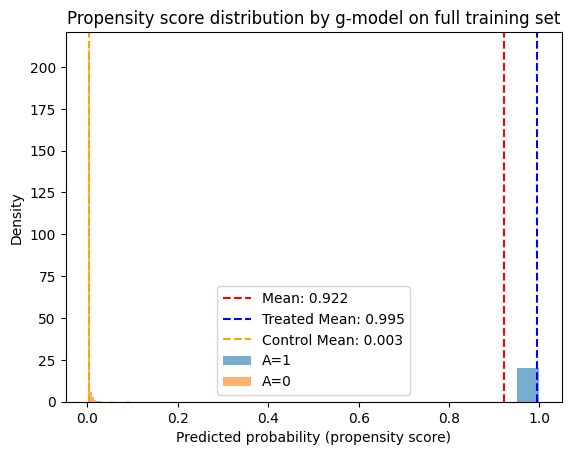

,set,Precision,Recall,F1,ROC_AUC,treated_mean,control_mean,mean
0,train_full,1.0,0.99844,0.999219,1.0,0.995235,0.002919,0.921846


In [144]:
g_w_train_full = calibrated_g_model.predict_proba(W_train_std)[:, 1]

# Performance Metrics
y_pred_g_model_full_train = (g_w_train_full >= 0.5).astype(int)

# calculate precision, recall, F1-score, ROC-AUC for g model on training set
treat_mean = g_w_train_full[data_splits['train']['A'] == 1].mean()
control_mean = g_w_train_full[data_splits['train']['A'] == 0].mean()
metrics_g_train = {
            'set': "train_full",
            "Precision": precision_score(data_splits['train']['A'], y_pred_g_model_full_train, zero_division=0),
            "Recall": recall_score(data_splits['train']['A'], y_pred_g_model_full_train, zero_division=0),
            "F1": f1_score(data_splits['train']['A'], y_pred_g_model_full_train, zero_division=0),
            "ROC_AUC": roc_auc_score(data_splits['train']['A'], g_w_train_full),
            "treated_mean": float(g_w_train_full[data_splits['train']['A'] == 1].mean()),
            "control_mean": float(g_w_train_full[data_splits['train']['A'] == 0].mean()),    
            "mean": float(g_w_train_full.mean())

        }
metrics_g_train_df = pd.DataFrame([metrics_g_train])
# plot g model on full training set

treated_g_model_full_train = g_w_train_full[data_splits['train']['A'] == 1]
control_g_model_full_train = g_w_train_full[data_splits['train']['A'] == 0]

mean_g_full_train = np.mean(g_w_train_full)
mean_g_treated_full_train = np.mean(treated_g_model_full_train)
mean_g_control_full_train = np.mean(control_g_model_full_train)

plt.axvline(mean_g_full_train, color="red", linestyle="--", 
                label=f"Mean: {mean_g_full_train:.3f}")
plt.axvline(mean_g_treated_full_train, color="blue", linestyle="--", 
                label=f"Treated Mean: {mean_g_treated_full_train:.3f}")
plt.axvline(mean_g_control_full_train, color="orange", linestyle="--", 
                label=f"Control Mean: {mean_g_control_full_train:.3f}")

plt.hist(treated_g_model_full_train, bins=20, alpha=0.6, label="A=1", density=True)
plt.hist(control_g_model_full_train, bins=20, alpha=0.6, label="A=0", density=True)
plt.xlabel("Predicted probability (propensity score)")
plt.ylabel("Density")
plt.title("Propensity score distribution by g-model on full training set")
plt.legend()
plt.show()


display(metrics_g_train_df)

## Calculating overlap weights for training set 

In [145]:
g_w_train_trimmed = np.clip(g_w_train_full, 0.03, 0.97)
overlap_weights_train = g_w_train_trimmed * (1 - g_w_train_trimmed)
H_overlap_train = data_splits['train']['A'] * (1 - g_w_train_trimmed) - (1 - data_splits['train']['A']) * g_w_train_trimmed
H_1_overlap_train = (1 - g_w_train_trimmed)
H_0_overlap_train = g_w_train_trimmed

## Estimating fluctuation parameters and update q model for training set

In [146]:
eps = tmle_fn.estimate_fluctuation_param(
                    data_splits['train']['Y'], Q_A_train, H_1_overlap_train, H_0_overlap_train, 
                    data_splits['train']['A'], H_overlap_train
                )
eps

📈 Estimating fluctuation parameter (Overlap Weighting)...
   Fluctuation parameter (epsilon): 0.318613


0.31861335529967993

# `Applying Testing data to Q model and g model`

## Q model on testing set

In [147]:
Q_A_test, Q_1_test, Q_0_test, Q_model_test_df_metrices = tmle_fn.predict_Q_models(sl, W_A_test_std, data_splits['test']['Y'], is_test=True)
Q_A_test_min = Q_A_test.min()
Q_A_test_max = Q_A_test.max()
Q_A_test_mean = Q_A_test.mean()


print(f"Q_A_test min: {Q_A_test_min:.4f}, max: {Q_A_test_max:.4f}, mean: {Q_A_test_mean:.4f}")
display(Q_model_test_df_metrices)

Q_A_test min: 0.0877, max: 0.9408, mean: 0.5086


,set,Precision,Recall,F1,ROC_AUC
0,test,0.741092,0.738442,0.739765,0.816081


## g model on testing set & calculating overlap weight

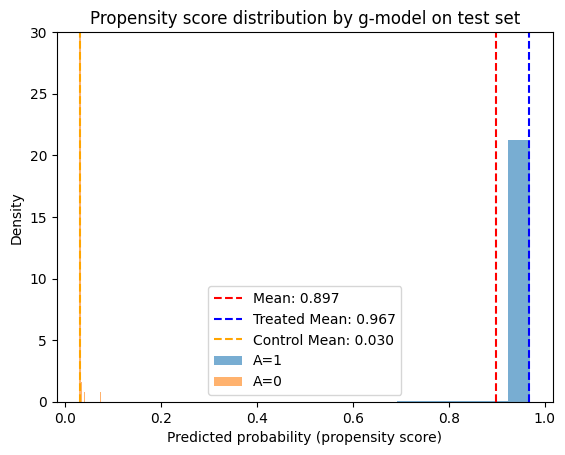

,set,Precision,Recall,F1,ROC_AUC,PS_treated_mean,PS_control_mean,PS_mean
0,test,1.0,0.99804,0.999019,1.0,0.966599,0.030109,0.897392


In [148]:
g_w_test = calibrated_g_model.predict_proba(W_test_std)[:, 1]
g_w_test_trimmed = np.clip(g_w_test, 0.03, 0.97)
# Performance Metrics on test set
y_pred_g_model_test = (g_w_test_trimmed >= 0.5).astype(int)
metrics_g_test = {
            'set': "test",
            "Precision": precision_score(data_splits['test']['A'], y_pred_g_model_test, zero_division=0),
            "Recall": recall_score(data_splits['test']['A'], y_pred_g_model_test, zero_division=0),
            "F1": f1_score(data_splits['test']['A'], y_pred_g_model_test, zero_division=0),
            "ROC_AUC": roc_auc_score(data_splits['test']['A'], g_w_test),
            "PS_treated_mean": float(g_w_test_trimmed[data_splits['test']['A'] == 1].mean()),
            "PS_control_mean": float(g_w_test_trimmed[data_splits['test']['A'] == 0].mean()),
            "PS_mean": float(g_w_test_trimmed.mean())

        }
metrics_g_test_df = pd.DataFrame([metrics_g_test])

# plot g model on test set
treated_g_model_test = g_w_test_trimmed[data_splits['test']['A'] == 1]
control_g_model_test = g_w_test_trimmed[data_splits['test']['A'] == 0]

mean_g_test = np.mean(g_w_test_trimmed)
mean_g_treated = np.mean(g_w_test_trimmed[data_splits['test']['A'] == 1])
mean_g_control = np.mean(g_w_test_trimmed[data_splits['test']['A'] == 0])
plt.axvline(mean_g_test, color="red", linestyle="--", 
                label=f"Mean: {mean_g_test:.3f}")
plt.axvline(mean_g_treated, color="blue", linestyle="--", 
                label=f"Treated Mean: {mean_g_treated:.3f}")
plt.axvline(mean_g_control, color="orange", linestyle="--", 
                label=f"Control Mean: {mean_g_control:.3f}")

plt.hist(treated_g_model_test, bins=20, alpha=0.6, label="A=1", density=True)
plt.hist(control_g_model_test, bins=20, alpha=0.6, label="A=0", density=True)
plt.xlabel("Predicted probability (propensity score)")
plt.ylabel("Density")
plt.title("Propensity score distribution by g-model on test set")
plt.ylim(0,30)
plt.legend()
plt.show()

display(metrics_g_test_df)

#calculating overlap weights and H terms for test set
g_w_test_trimmed = np.clip(g_w_test, 0.03, 0.97)
overlap_weights_test = g_w_test_trimmed * (1 - g_w_test_trimmed)
H_overlap_test = data_splits['test']['A'] * (1 - g_w_test_trimmed) - (1 - data_splits['test']['A']) * g_w_test_trimmed
H_1_overlap_test = (1 - g_w_test_trimmed)
H_0_overlap_test = g_w_test_trimmed

## Update Q model on test set

In [149]:
Q_A_update_test = tmle_fn.update_Q(Q_A_test, H_overlap_test, eps)
Q_1_update_test = tmle_fn.update_Q(Q_1_test, H_1_overlap_test, eps)
Q_0_update_test = tmle_fn.update_Q(Q_0_test, - H_0_overlap_test, eps)

### Computing ATE

In [150]:
result = tmle_fn.compute_tmle(
    data_splits['test']['Y'], data_splits['test']['A'],
    Q_A_update_test, Q_1_update_test, Q_0_update_test,
    H_1_overlap_test, H_0_overlap_test,
    overlap_weights_test, H_overlap_test
)

result

🎯 Computing TMLE estimates ATE...


,Estimand,Estimate,Std.Err,95% CI,P-value
0,ATE,0.061572,0.000387,"[0.060812, 0.062331]",0.0
